In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter, median_filter, convolve 
from skimage.morphology import opening, closing
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, estimate_sigma
from skimage.filters import threshold_local

## Pré Processamento

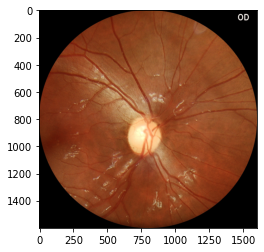

In [2]:
img = imageio.imread('images/4.jpg')
plt.imshow(img)

(1600, 1600)


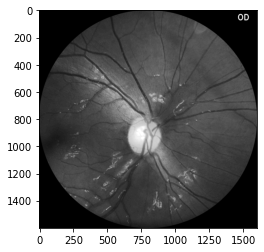

In [3]:
img_g = img[:,:,1]
print(img_g.shape)
plt.imshow(img_g,cmap='gray')

In [4]:
def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

def filter_img(img, kernel_size=3, filter_type="mean"):
    if filter_type == "mean":
        weights = np.full((kernel_size, kernel_size), 1.0/(kernel_size**2))
        return convolve(img, weights=weights, mode="constant", cval=0)
    elif filter_type == "median":
        return median_filter(img, size=kernel_size)
    elif filter_type == "gaussian":
        return convolve(img, weights=gkern(kernel_size, sig= (0.3*(kernel_size/2 - 1) + 0.8)), mode="constant", cval=0)
#         return gaussian_filter(img, sigma=kernel_size)
    else:
        print('Error! Filter should be either mean or median!')
        return None

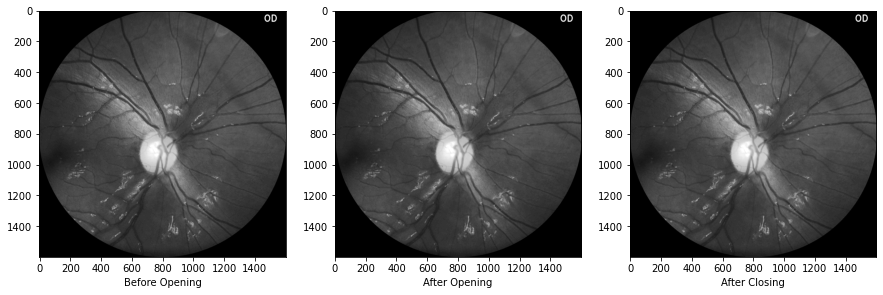

In [5]:
ker = np.array([[1,1,1],[1,1,1],[1,1,1]]).astype(np.uint8)
ker = np.ones((3, 3))
img_opening = opening(img_g, ker)
img_closing = closing(img_g, ker)

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.xlabel('Before Opening')
plt.imshow(img_g, cmap="gray")
plt.subplot(132)
plt.xlabel('After Opening')
plt.imshow(img_opening, cmap="gray")
plt.subplot(133)
plt.xlabel('After Closing')
plt.imshow(img_closing, cmap="gray")

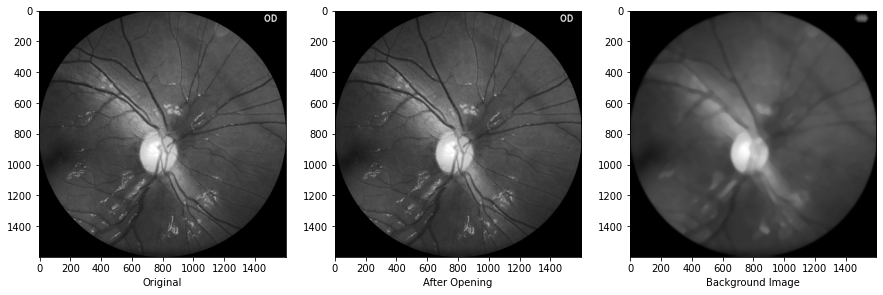

In [6]:
background = filter_img(img_opening, kernel_size=3, filter_type="mean")
background = filter_img(background, kernel_size=31, filter_type="gaussian")
background = filter_img(background, kernel_size=40, filter_type="median")

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.xlabel("Original")
plt.imshow(img_g, cmap="gray")
plt.subplot(132)
plt.xlabel("After Opening")
plt.imshow(img_opening, cmap="gray")
plt.subplot(133)
plt.xlabel("Background Image")
plt.imshow(background, cmap="gray")

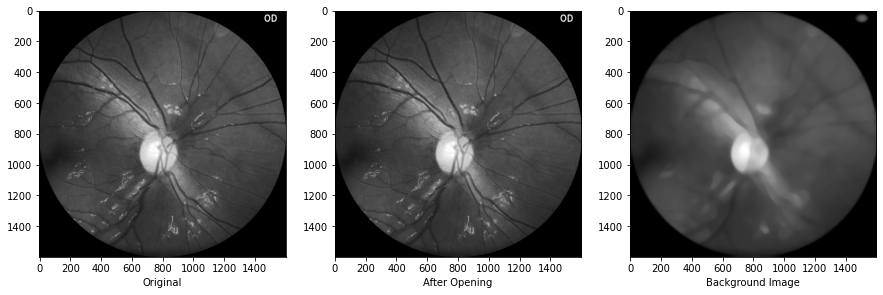

In [7]:
background_15 = filter_img(img_opening, kernel_size=13, filter_type="mean")
background_15 = filter_img(background, kernel_size=15, filter_type="gaussian")
background_15 = filter_img(background, kernel_size=40, filter_type="median")

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.xlabel("Original")
plt.imshow(img_g, cmap="gray")
plt.subplot(132)
plt.xlabel("After Opening")
plt.imshow(img_opening, cmap="gray")
plt.subplot(133)
plt.xlabel("Background Image")
plt.imshow(background_15, cmap="gray")

In [8]:
def histogram(A, no_levels):
    # gets the size of the input matrix
    N, M = A.shape
    # creates an empty histogram with size proportional to the number of graylevels 
    hist = np.zeros(no_levels).astype(int)

    # computes for all levels in the range
    for i in range(no_levels):
        # sum all positions in which A == i is true
        pixels_value_i = np.sum(A == i)
        # store it in the histogram array
        hist[i] = pixels_value_i
            
    return(hist)

def histogram_equalization(A, no_levels):
    # computes the image histogram
    hist = histogram(A,  no_levels)
    
    # creates an empty cumulative histogram
    histC = np.zeros(no_levels).astype(int)

    # computes the cumulative histogram
    histC[0] = hist[0] # first value (intensity 0)
    # from intensity 1 to no_levels-1
    for i in range(1,  no_levels):
        histC[i] = hist[i] + histC[i-1]

    # the vector below is used to store the actual transformation function
    # it allows us to later visualize what was the function that computed
    # the equalisation
    hist_transform = np.zeros(no_levels).astype(np.uint8)
    
    # gets the size of the input image
    N, M = A.shape
    
    # create the image to store the equalised version
    A_eq = np.zeros([N,M]).astype(np.uint8)
    
    # for each intensity value, transforms it into a new intensity
    # using the np.where() function 
    for z in range(no_levels):
        # computes what would be the output level 's' for an input value 'z'
        s = ((no_levels-1)/float(M*N))*histC[z]
        
        # for every coordinate in which matrix A has the value 'z'
        # assigns the transformed/equalised value 's'
        A_eq[ np.where(A == z) ] = s
        
        # store the tranformation function
        hist_transform[z] = s
    
    return (A_eq, hist_transform)

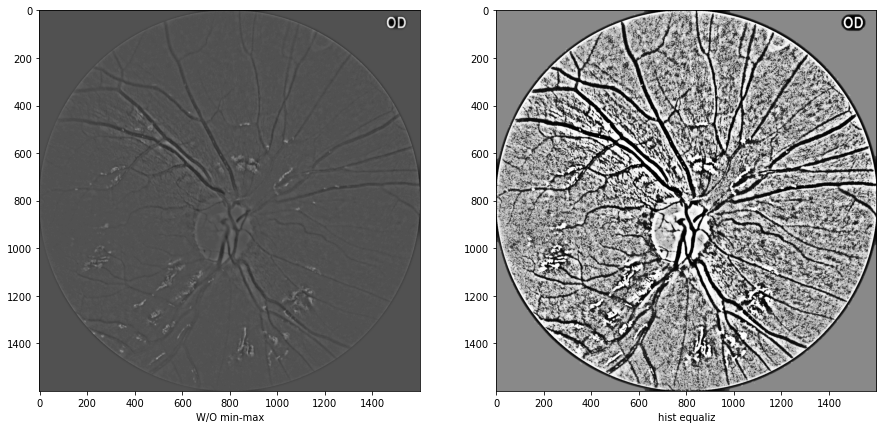

In [9]:
diff_img = img_opening.astype(np.int64) - background.astype(np.int64)
diff_img = ((diff_img - np.min(diff_img)) / (np.max(diff_img) - np.min(diff_img))*255).astype(np.uint8)
test, _ = histogram_equalization(diff_img, 256)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.xlabel("W/O min-max")
plt.imshow(diff_img, cmap="gray")

plt.subplot(122)
plt.xlabel("hist equaliz")
plt.imshow(test, cmap="gray")

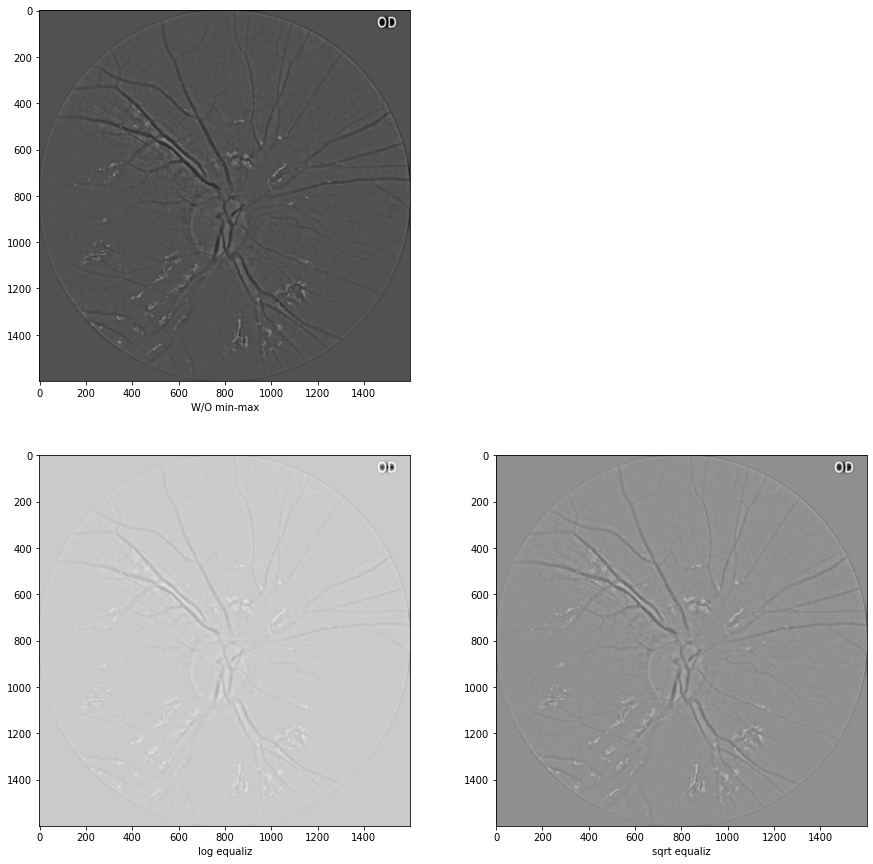

In [10]:

test_1 = np.sqrt(diff_img)
test_1 = ((test_1 - np.min(test_1)) / (np.max(test_1) - np.min(test_1)) * 255).astype(np.uint8)

test_2 = np.log(diff_img.astype(np.uint16) + 1)
test_2 = ((test_2 - np.min(test_2)) / (np.max(test_2) - np.min(test_2)) * 255).astype(np.uint8)

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.xlabel("W/O min-max")
plt.imshow(diff_img, cmap="gray")

plt.subplot(223)
plt.xlabel("log equaliz")
plt.imshow(test_2, cmap="gray")

plt.subplot(224)
plt.xlabel("sqrt equaliz")
plt.imshow(test_1, cmap="gray")

In [11]:
diff_img = ((diff_img - np.min(diff_img)) / (np.max(diff_img) - np.min(diff_img))*255).astype(np.uint8)
print(np.min(diff_img))
print(np.max(diff_img))

0
255


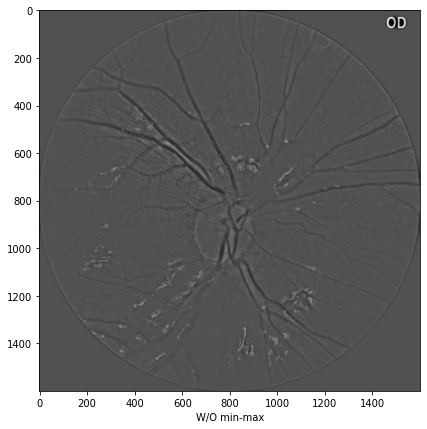

In [12]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.xlabel("W/O min-max")
plt.imshow(diff_img, cmap="gray")

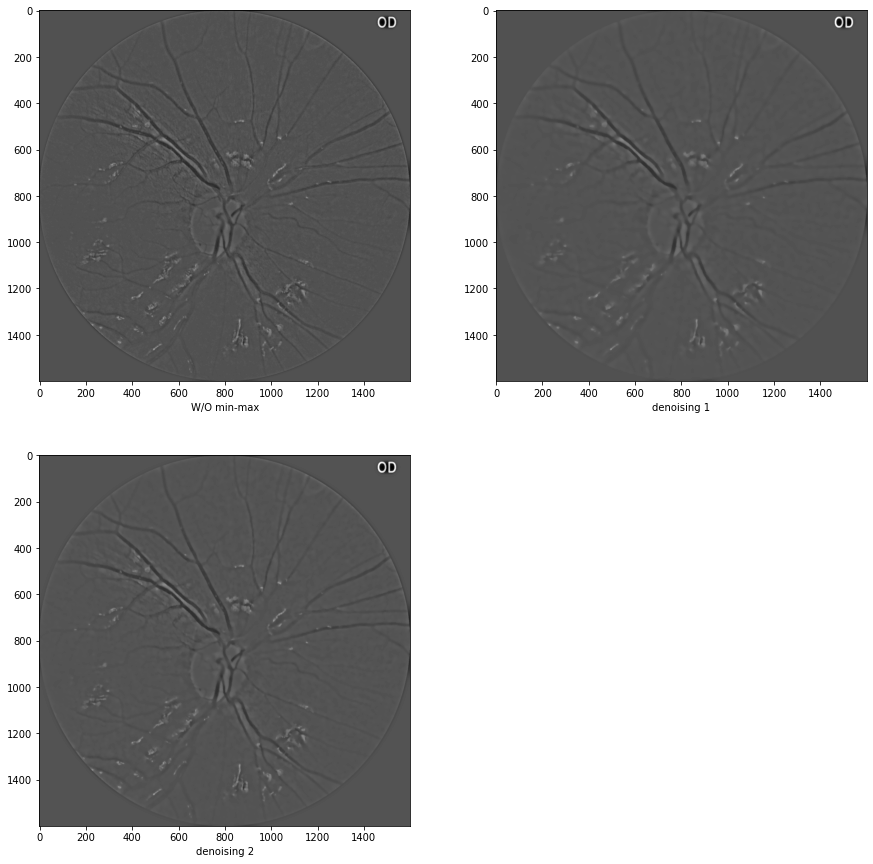

In [13]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.xlabel("W/O min-max")
plt.imshow(diff_img, cmap="gray")

# try to clean bg (gaussian maybe, to remove noise)
denoised_1 = denoise_tv_chambolle(diff_img, weight=0.15)
plt.subplot(222)
plt.xlabel("denoising 1")
plt.imshow(denoised_1, cmap="gray")

denoised_2 = denoise_tv_chambolle(diff_img, weight=0.05)
plt.subplot(223)
plt.xlabel("denoising 2")
plt.imshow(denoised_2, cmap="gray")

## Processamento

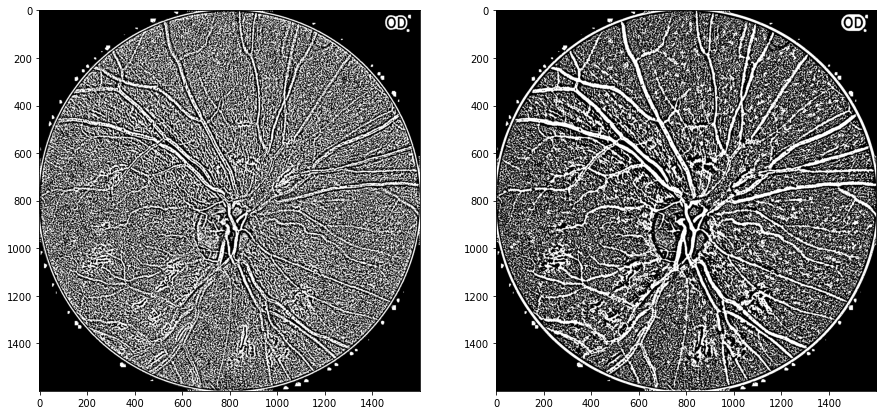

In [14]:
plt.figure(figsize=(15,15))

parameter = 3
block_size = 15
thresh_1 = threshold_local(diff_img, block_size=block_size, method='gaussian', param=parameter)
thresh_img_1 = diff_img < thresh_1
thresh_2 = threshold_local(test, block_size=block_size, method='gaussian', param=parameter)
thresh_img_2 = test < thresh_2

plt.subplot(121)
plt.imshow(thresh_img_1, cmap='gray')
plt.subplot(122)
plt.imshow(thresh_img_2, cmap='gray')



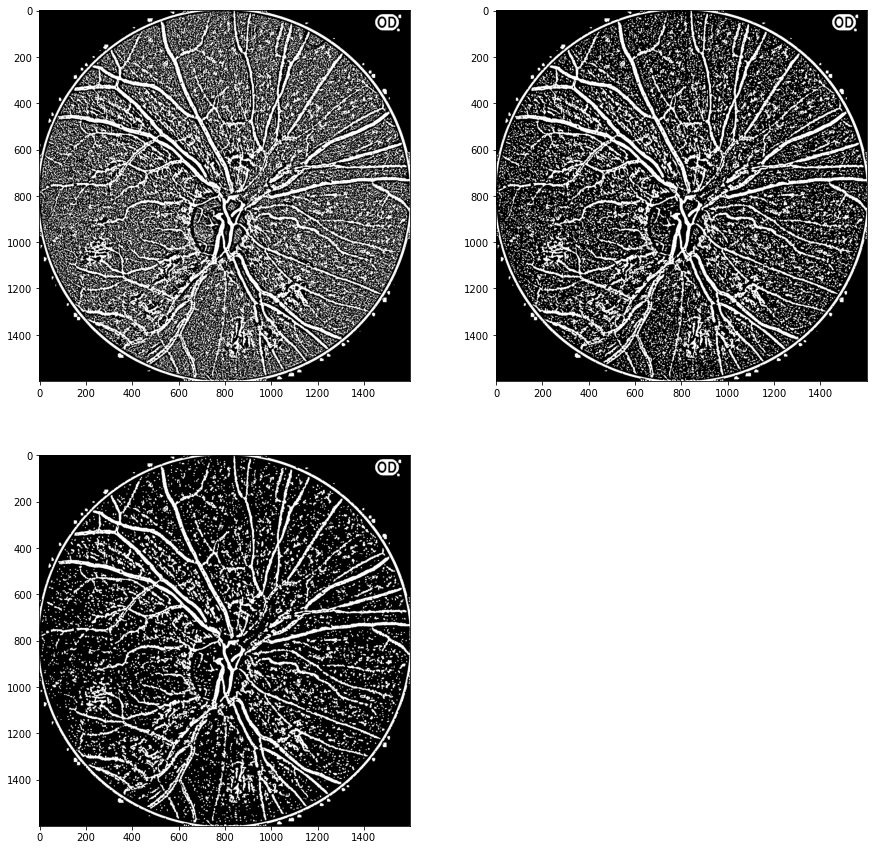

In [15]:
plt.figure(figsize=(15,15))
denoise_thresh = opening(thresh_img_2, np.ones((3,3)))
denoise_thresh_1 = opening(thresh_img_2, np.ones((4,4)))

plt.subplot(221)
plt.imshow(thresh_img_2, cmap='gray')
plt.subplot(222)
plt.imshow(denoise_thresh, cmap='gray')
plt.subplot(223)
plt.imshow(denoise_thresh_1, cmap='gray')


### Next steps

Remove 'dots' from image above, and try running a `closing`, to connect the lines (blood vessels)